In [46]:
# load Python/Theano stuff
# Show figures inline with the code
%matplotlib inline   

import theano
import theano.tensor as T
import theano.tensor.nlinalg as Tla
import lasagne       # the library we're using for NN's
# import the nonlinearities we might use 
from lasagne.nonlinearities import leaky_rectify, softmax, linear, tanh, rectify
from theano.tensor.shared_randomstreams import RandomStreams
import numpy as np
from numpy.random import *
from matplotlib import pyplot as plt

import cPickle
import sys

# import kmeans clustering algorithm from scikit-learn
from sklearn.cluster import KMeans 


In [47]:
# Load our code

# Add all the paths that should matter right now
sys.path.append('lib/') 
from GenerativeModel import *       # Class file for generative models. 
from RecognitionModel import *      # Class file for recognition models
from VIMCO import *

# import our covariance-plotting software
from plot_cov import *


In [48]:
# Use the fast compile option
theano.config.optimizer = 'fast_compile' 

In [49]:
# Choose Simulation Parameters and Generate Data
xDim = 3 # number of latent classes
yDim = 2 # dimensionality of Gaussian observations
_N = 2500 # number of datapoints to generate
gmm = MixtureOfGaussians(dict([]), xDim, yDim)  # instantiate our 'true' generative model
[xsamp, ysamp] = gmm.sampleXY(_N)
[xtrain, ytrain] = gmm.sampleXY(_N)

In [50]:
# Set up Lasagne Recognition Network 
rec_is_training = theano.shared(value = 1) 
rec_nn = lasagne.layers.InputLayer((None, yDim))
rec_nn = lasagne.layers.DenseLayer(rec_nn, 100, nonlinearity=leaky_rectify, W=lasagne.init.Orthogonal())
rec_nn = lasagne.layers.DenseLayer(rec_nn, xDim, nonlinearity=softmax, W=lasagne.init.Orthogonal(), b=5*np.ones(xDim, dtype=theano.config.floatX))
NN_Params = dict([('network', rec_nn)])
recDict = dict([('NN_Params'     , NN_Params)
                ])

In [ ]:
# construct a dummy model 
opt_params = dict({'c0': -0.0, 'v0': 1.0, 'alpha': 0.9})
model = BuildModel(opt_params, dict([]), MixtureOfGaussians, recDict, GMMRecognition, xDim, yDim)

# # Initialize generative model at the k-means solution
# km = KMeans(n_clusters=xDim, n_init=10, max_iter=500)
# kmpred = km.fit_predict(ytrain)

# km_mu = np.zeros([xDim, yDim])
# km_chol = np.zeros([xDim, yDim, yDim])
# for cl in np.unique(kmpred):
#     km_mu[cl] = ytrain[kmpred == cl].mean(axis=0)
#     km_chol[cl] = np.linalg.cholesky(np.cov(ytrain[kmpred == cl].T))
    
# model.mprior.mu.set_value(km_mu.astype(theano.config.floatX))
# model.mprior.RChol.set_value(km_chol.astype(theano.config.floatX))

# km_pi = np.histogram(kmpred,bins=xDim)[0]/(1.0*kmpred.shape[0])
# model.mprior.pi_un.set_value(km_pi.astype(theano.config.floatX))

In [ ]:
# center our simluated data around the mean
# ysamp_mean = ysamp.mean(axis=0, dtype=theano.config.floatX)
# ytrain = ysamp - ysamp_mean

# Fit the model
costs = model.fit(ytrain, batch_size = 5, max_epochs = 10, nSamp = 30, learning_rate=2e-3)

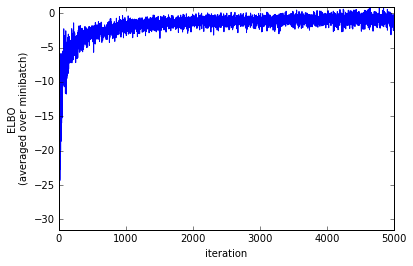

In [ ]:
# Plot ELBO (variational lower bound objective) against iteration
plt.figure()
plt.plot(costs)
plt.axis('tight')
plt.xlabel('iteration')
plt.ylabel('ELBO\n(averaged over minibatch)')

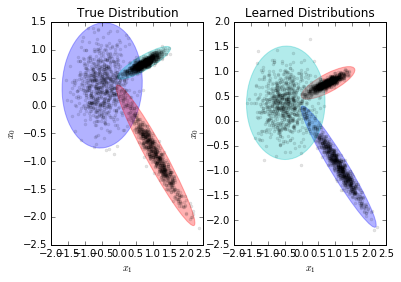

In [ ]:
clr = ['b', 'r', 'c','g','m','o']

plt.figure()
plt.subplot(121)
plt.plot(ysamp[:,0], ysamp[:,1],'k.', alpha=.1)
plt.hold('on')
for ii in xrange(xDim):
    Rc= gmm.RChol[ii].eval()
    plot_cov_ellipse(Rc.dot(Rc.T), gmm.mu[ii].eval(), nstd=3, color=clr[ii%5], alpha=.3)
    
plt.title('True Distribution')
plt.ylabel(r'$x_0$')
plt.xlabel(r'$x_1$')

plt.subplot(122)
plt.hold('on')
plt.plot(ytrain[:,0], ytrain[:,1],'k.', alpha=.1)
for ii in xrange(xDim):
    Rc= model.mprior.RChol[ii].eval()
    plot_cov_ellipse(Rc.dot(Rc.T), model.mprior.mu[ii].eval(), nstd=3, color=clr[ii%5], alpha=.3)
    
plt.title('Learned Distributions')    
plt.ylabel(r'$x_0$')
plt.xlabel(r'$x_1$')

plt.show()

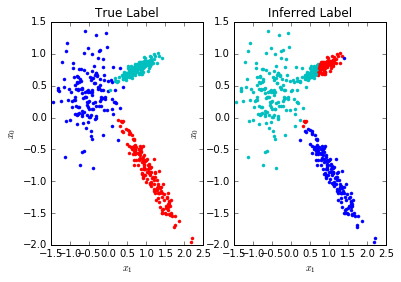

In [ ]:
xlbl = xsamp.nonzero()[1]
#learned_lbl = model.mrec.h.eval({model.Y:ytrain}).argmax(axis=1)
#learned_lbl = model.mrec.getSample(ysamp).argmax(axis=1)
learned_lbl = model.mrec.h.argmax(axis=1).eval({model.Y:ysamp})

clr = ['b', 'r', 'c','g','m','o']

plt.figure()
for ii in np.random.permutation(xrange(500)):
    plt.subplot(121)
    plt.hold('on')
    plt.plot(ysamp[ii,0] ,ysamp[ii,1],'.', color = clr[xlbl[ii]%5])
    plt.subplot(122)
    plt.hold('on')
    plt.plot(ysamp[ii,0] ,ysamp[ii,1],'.', color = clr[learned_lbl[ii]%5])
    
plt.subplot(121)
plt.title('True Label')
plt.ylabel(r'$x_0$')
plt.xlabel(r'$x_1$')
plt.subplot(122)
plt.title('Inferred Label')
plt.ylabel(r'$x_0$')
plt.xlabel(r'$x_1$')
    
plt.show()


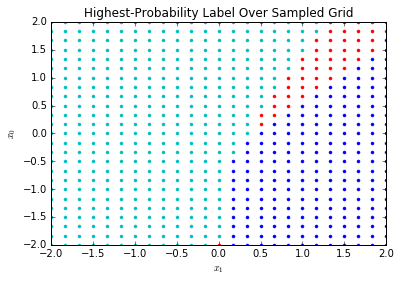

In [ ]:
n = 25

x = np.linspace(-2, 2, n)
y = np.linspace(-2, 2, n)
xv, yv = np.meshgrid(x, y)
grid= np.vstack([xv.flatten(), yv.flatten()]).T

#gridlabel = model.mrec.getSample(grid.astype(theano.config.floatX)).argmax(axis=1)

gridlabel = model.mrec.h.argmax(axis=1).eval({model.Y:grid.astype(theano.config.floatX)})

plt.figure()
plt.hold('on')
for ii in xrange(n*n):
    plt.plot(grid[ii,0] ,grid[ii,1],'.', color = clr[gridlabel[ii]%5])
plt.ylabel(r'$x_0$')
plt.xlabel(r'$x_1$')
plt.title('Highest-Probability Label Over Sampled Grid')
plt.show()